In [2]:
# ipython kernel install --user --name=venv
import pandas as pd
import numpy as np
from pandas import json_normalize
from functools import reduce
import matplotlib.pyplot as plt
from itables import show
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, mean_squared_error, r2_score
from sklearn.tree import export_graphviz
from scipy.stats import randint

In [3]:
CAMPINAS_CODE = "3509502"
SAO_PAULO_CODE = "3550308"
CAPELINHA_CODE = "3112307"
INDAIATUBA_CODE = "3520509"

In [65]:
DATA_PATH = "../data/processed/final_NCR/final_total_total_data_without_nan.csv"
TARGET_COLUMN = "TXT_FUN_TX_EVASAO_TOTAL"
COLUMNS_TO_DROP = ["CO_MUNICIPIO", "ANO"]

In [66]:
filtered_data = pd.read_csv(DATA_PATH, delimiter=";")
trainning_df = filtered_data.drop(COLUMNS_TO_DROP, axis=1)

trainning_df.dropna(inplace=True)

X = trainning_df.drop(TARGET_COLUMN, axis=1).select_dtypes(exclude=['object']).values
normX = X / np.linalg.norm(X)

y = trainning_df[TARGET_COLUMN]
normY = y / np.linalg.norm(y)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [68]:
rf = RandomForestRegressor(oob_score=True)
rf.fit(X_train, y_train)

RandomForestRegressor(oob_score=True)

In [69]:
y_pred = rf.predict(X_test)

In [70]:
oob_score = rf.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("RMSE: ", rmse)

Out-of-Bag Score: 0.8030258800499523
Mean Squared Error: 0.6006124690654672
R-squared: 0.7982443140794278
RMSE:  0.775


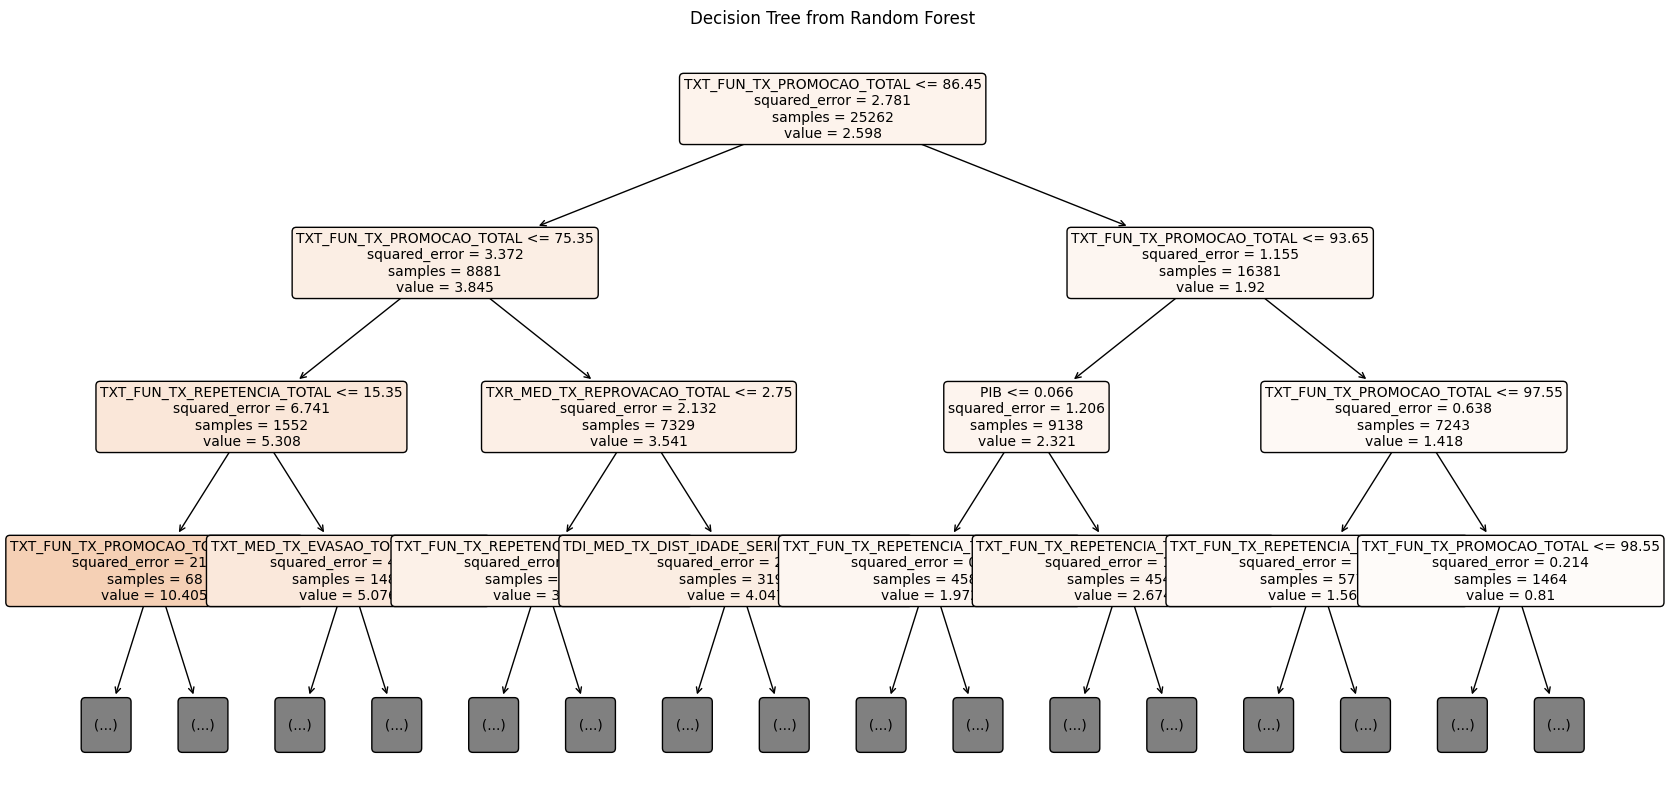

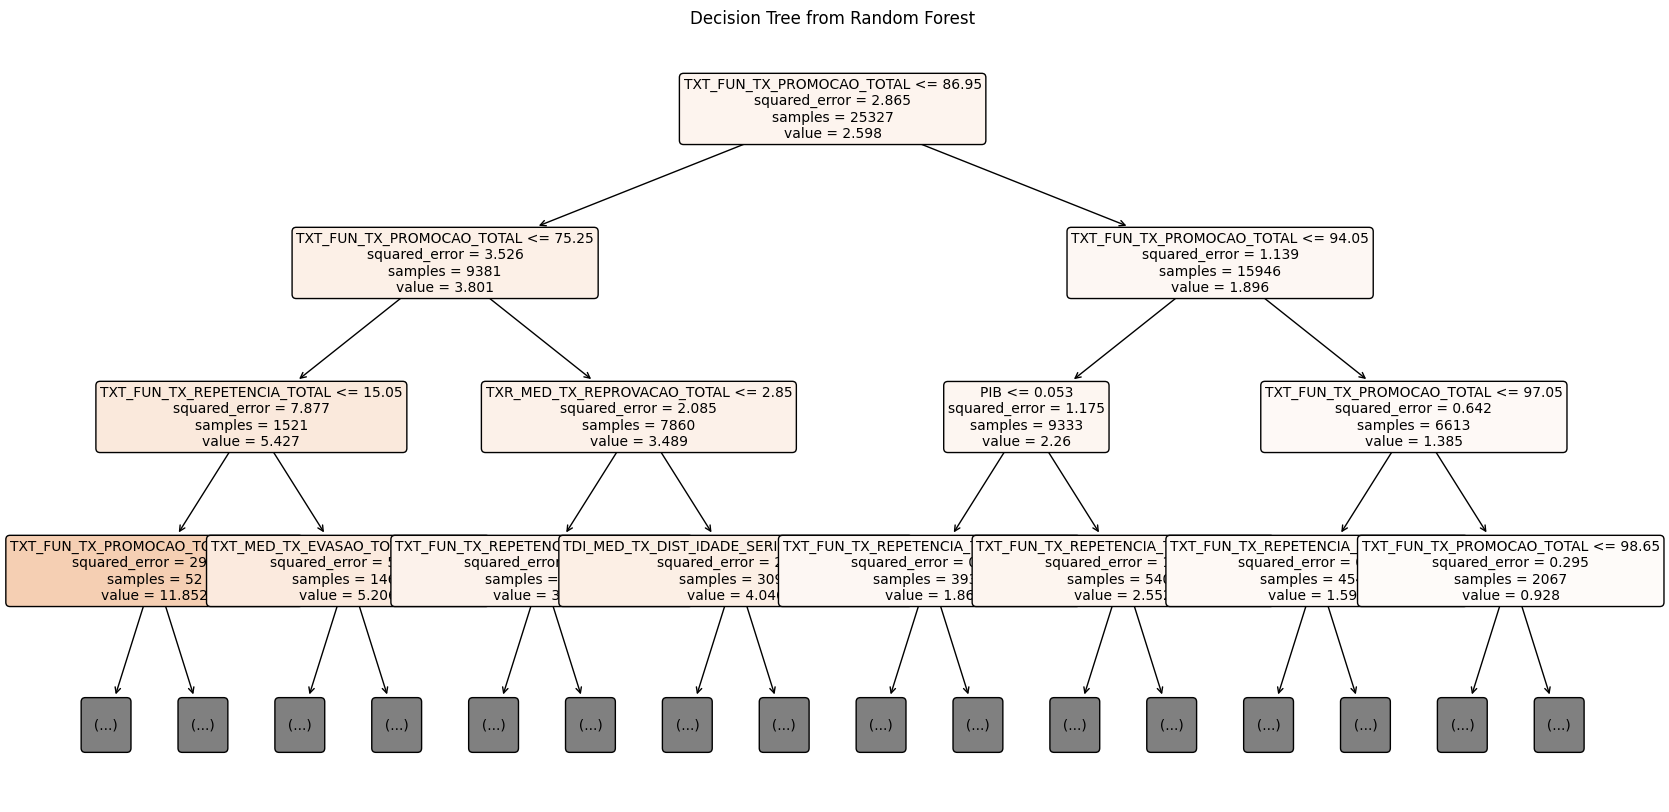

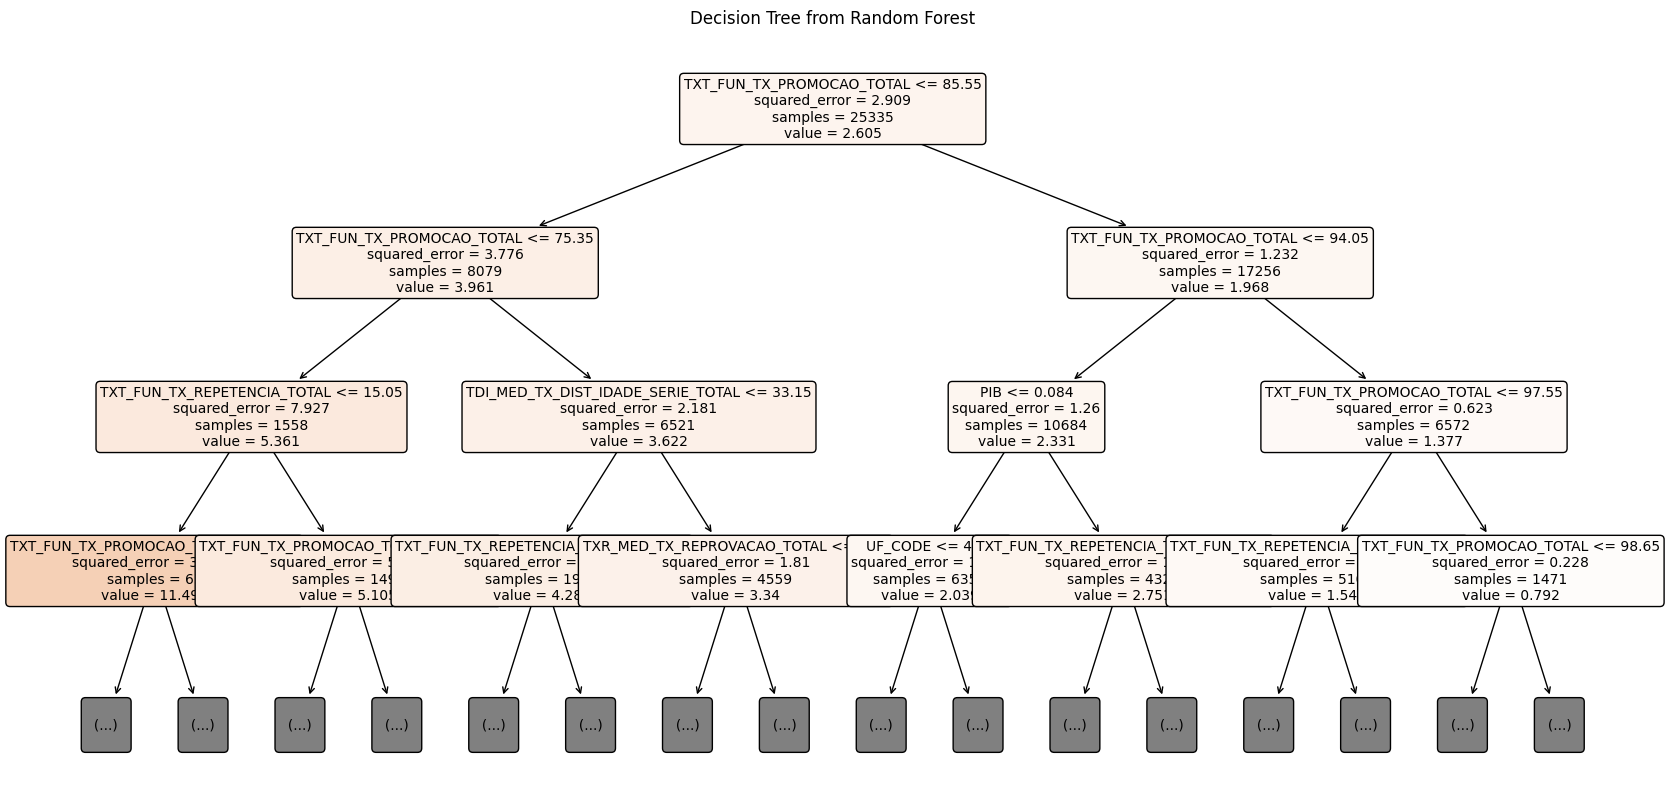

In [71]:
from sklearn.tree import plot_tree

for i in range(3):
    tree = rf.estimators_[i]
    plt.figure(figsize=(20, 10))
    plot_tree(tree, feature_names=trainning_df.columns.tolist(), filled=True, rounded=True, fontsize=10, max_depth=3)
    plt.title("Decision Tree from Random Forest")
    plt.show()

<Axes: >

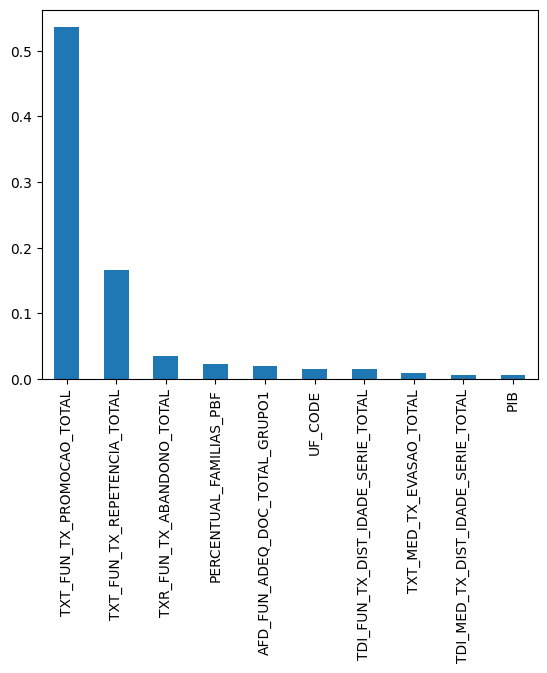

In [72]:
feature_importances = pd.Series(rf.feature_importances_, index=trainning_df.drop(TARGET_COLUMN, axis=1).select_dtypes(exclude=['object']).columns).sort_values(ascending=False)[:10]

# Plot a simple bar chart
feature_importances.plot.bar()

In [22]:
param_dist = {'n_estimators': randint(1,500),
              'max_depth': randint(1,20)}

rf = RandomForestRegressor(oob_score=True)

rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(oob_score=True),
                   n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025D5FACA050>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000025D60683390>})

In [23]:
best_rf = rand_search.best_estimator_

print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 13, 'n_estimators': 195}


In [24]:
oob_score = best_rf.oob_score_
print(f'Out-of-Bag Score: {oob_score}')

y_pred = best_rf.predict(X_test)

# Evaluating the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
 
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

rmse = float(format(np.sqrt(mean_squared_error(y_test, y_pred)), '.3f'))
print("RMSE: ", rmse)

Out-of-Bag Score: 0.7461272054264847
Mean Squared Error: 1.075547582173226
R-squared: 0.6920049938972154
RMSE:  1.037


# Curva Viés-Variancia

In [27]:
import matplotlib.pyplot as plt

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Initialize lists to store bias and variance values
depths = range(1, 21)
train_errors = []
test_errors = []

# Train Random Forest models with varying depths
for depth in depths:
    rf = RandomForestRegressor(max_depth=depth)
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Calculate training error (bias)
    y_train_pred = rf.predict(X_train)
    train_error = mean_squared_error(y_train, y_train_pred)
    train_errors.append(train_error)
    
    # Calculate testing error (variance)
    y_test_pred = rf.predict(X_test)
    test_error = mean_squared_error(y_test, y_test_pred)
    test_errors.append(test_error)

# Plot bias-variance curve
plt.figure(figsize=(10, 6))
plt.plot(depths, train_errors, label='Train Error (Bias^2)', color='blue')
plt.plot(depths, test_errors, label='Test Error (Variance)', color='red')
plt.xlabel('Tree Depth')
plt.ylabel('Mean Squared Error')
plt.title('Bias-Variance Tradeoff with Random Forest')
plt.legend()
plt.show()

KeyboardInterrupt: 